# Using NLP Technique and Machine Learning Models to Analyze Text Messages and Classify Whether a Text Message is a Spam or Not

**Mac/Unix**

From the terminal:
1. Install NLTK: run `pip install -U nltk`
2. Test installation: run `python` then type `import nltk`

**Windows**

1. Install NLTK: [http://pypi.python.org/pypi/nltk](http://pypi.python.org/pypi/nltk)
2. Test installation: `Start>Python35`, then type `import nltk`

In [5]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score

import time
import re
import string


In [7]:
%matplotlib inline
rcParams['figure.figsize']=12,8
sb.set_style('whitegrid')

In [8]:
stopwords = nltk.corpus.stopwords.words('english')

In [9]:
# For this project we will use lemmatizer instead of Stemmer which is faster but less accurate.
wn = nltk.WordNetLemmatizer()

In [10]:
# For this project we will also use Term Frequency-Inverse Document Frequency Vectorizer method instead of Count Vectorizer or N-Gram
from sklearn.feature_extraction.text import TfidfVectorizer 

# Import Data

In [11]:
data = pd.read_csv('SMSSpamCollection.tsv', sep='\t', header=None)
data.columns = ['label', 'body_text']
data.head()

,label,body_text
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


# Create New Features

In [12]:
# Create 2 new features body_len and punct% to represent the length of each text and the percentage of punctuation respectively.
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))

In [13]:
data.head()

,label,body_text,body_len
0,ham,I've been searching for the right words to tha...,160
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128
2,ham,"Nah I don't think he goes to usf, he lives aro...",49
3,ham,Even my brother is not like to speak with me. ...,62
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28


In [14]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")), 3)*100

In [15]:
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

In [16]:
data.head()

,label,body_text,body_len,punct%
0,ham,I've been searching for the right words to tha...,160,2.5
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
2,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1
3,ham,Even my brother is not like to speak with me. ...,62,3.2
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1


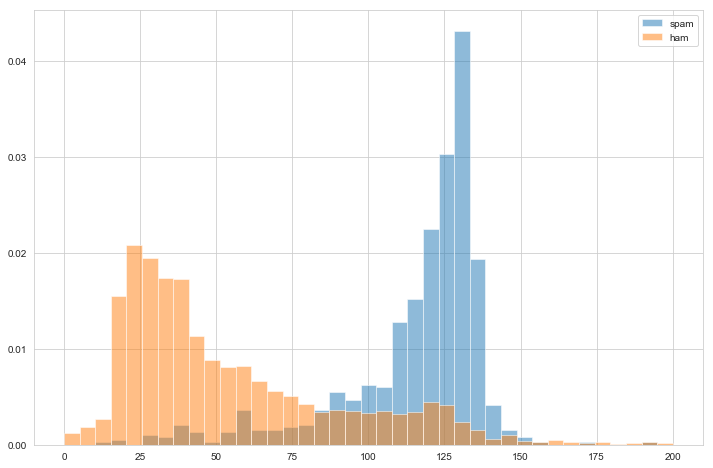

In [17]:
# PLot the histograms of these 2 new features to see if there is any obvious separation between "spam" and "ham"
bins = np.linspace(0,200,40)
plt.hist(data[data['label'] == 'spam']['body_len'],  bins, alpha = 0.5, density = True, label = 'spam' )
plt.hist(data[data['label'] == 'ham']['body_len'], bins, alpha = 0.5, density = True, label = 'ham' )
plt.legend(loc='upper right')
plt.show()

# It seems that body_len is a good predictor for machine learning modeling

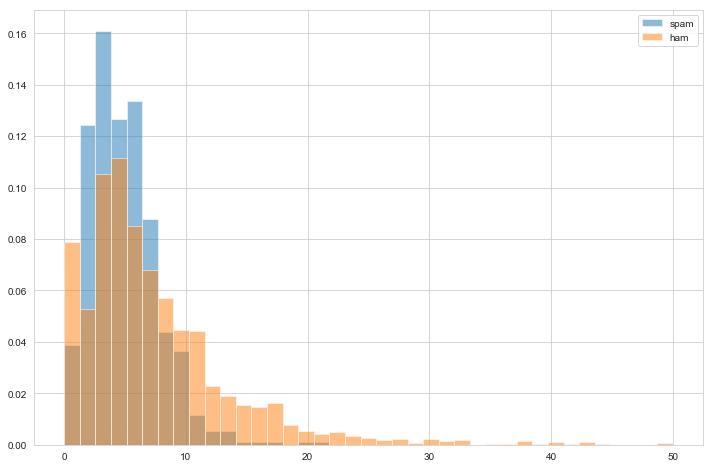

In [18]:
bins = np.linspace(0,50,40)
plt.hist(data[data['label'] == 'spam']['punct%'],  bins, alpha = 0.5, density = True, label = 'spam' )
plt.hist(data[data['label'] == 'ham']['punct%'], bins, alpha = 0.5, density = True, label = 'ham' )
plt.legend(loc='upper right')
plt.show()

# punct% does not seem to separate well between "spam" and "ham" but we will keep it for now

# Create Term Frequency-Inverse Document Frequency Matrix

In [19]:
# Define a function to remove punctuation, tokenize, remove stopwords, and lemmatize each text
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

In [20]:
# Pass in the clean_text function and create Tfidf data frame
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df.head()

,,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,...,zindgi,zoe,zogtorius,zoom,zouk,zyada,é,ü,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Concatenate data frames to create features for modeling
X_features = pd.concat([data['body_len'], data['punct%'], X_tfidf_df], axis=1)
X_features.head()

,body_len,punct%,,0,008704050406,0089my,0121,01223585236,01223585334,0125698789,...,zindgi,zoe,zogtorius,zoom,zouk,zyada,é,ü,üll,〨ud
0,160,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Building Random Forest Model

In [22]:
# Split the dataset with 80% training set and 20% test set
Y = data['label']
X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state = 0)

In [23]:
# Create a Random Forest classifier with 1,000 bootstrap samples.
rf = RandomForestClassifier(n_estimators=1000,random_state = 0, n_jobs=-1)
# Train the model using training data set.
start_time = time.time()
rf_model = rf.fit(X_train,Y_train)
end_time = time.time()
fit_time = end_time - start_time

# Make prediction using test dataset.
start_time = time.time()
Y_pred = rf_model.predict(X_test)
end_time = time.time()
pred_time = end_time - start_time

# Calculate the class probabilities for label "1"
rf_probs = rf_model.predict_proba(X_test)[:, 1]
# Calculate ROC-AUC
auc_value = roc_auc_score(Y_test, rf_probs)

print('The ROC-AUC Value for Random Forest Classifier is :',round(auc_value,3))

precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label = 'spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), 
    round(accuracy_score(Y_test, Y_pred), 3)))

The ROC-AUC Value for Random Forest Classifier is : 0.997
Fit time: 50.349 / Predict time: 0.716 ---- Precision: 1.0 / Recall: 0.855 / Accuracy: 0.979


In [24]:
# Random Forest results are really good!

# Building Gradient Boosting Model

In [25]:
# Use the last settting from Random Forest again to build a Gradient Boosting to compare apple to apple.
# The default max_depth for Gradient Boosting is 3. 
# We can increase this number to 7 and see whether the model performance is better.
gb = GradientBoostingClassifier(random_state = 0, n_estimators = 1000, max_depth = 7)
    
start_time = time.time()
gb_model = gb.fit(X_train, Y_train)
end_time = time.time()
fit_time = end_time - start_time

start_time = time.time()
Y_pred = gb_model.predict(X_test)
end_time = time.time()
pred_time = (end_time - start_time)

# Calculate the class probabilities for label "1"
gb_probs = gb_model.predict_proba(X_test)[:, 1]
# Calculate ROC AUC
auc_value = roc_auc_score(Y_test, gb_probs)

print('The ROC-AUC Value for Gradient Boosting Classifier is :',round(auc_value,3))

precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label = 'spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), 
    round(accuracy_score(Y_test, Y_pred), 3)))


The ROC-AUC Value for Gradient Boosting Classifier is : 0.984
Fit time: 1017.748 / Predict time: 0.25 ---- Precision: 0.979 / Recall: 0.893 / Accuracy: 0.982
